In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import sys

#from google.colab import drive, files
from matplotlib.image import imread
from os import makedirs
from os import listdir
from shutil import copyfile
from tensorflow.config import list_physical_devices
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from torch import cuda

In [31]:
# reorganize images in train into categorized training and validation set
dataset_home = 'dogs_v_cats/'
subdirs = ['train/', 'validation/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
random.seed(42)
# 80/20 training/validation ratio for training data
val_ratio = 0.2
# copy training dataset images into new directories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random.random() < val_ratio:
        dst_dir = 'validation/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)


replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [39]:
image = imread("/Users/Macbook/Desktop/Week_8/dogs_v_cats/train/cats/cat.2.jpg")

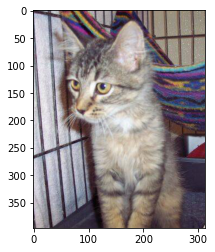

In [40]:
plt.imshow(image)
plt.show()

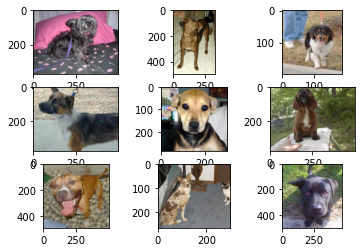

In [45]:
# plot dog photos from the dataset
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
# define subplot
    plt.subplot(330 + 1 + i)
# define filename
    filename = folder + 'dog.' + str(i) + '.jpg'
# load image pixels
    image = imread(filename)
# plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

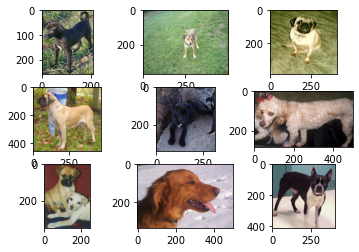

In [49]:
# plot random dog photos from original training dataset
from matplotlib import pyplot
from matplotlib.image import imread
folder = './train/'
for i in range(9):
    rand_img = random.randint(0, 12499)
    plt.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(rand_img) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

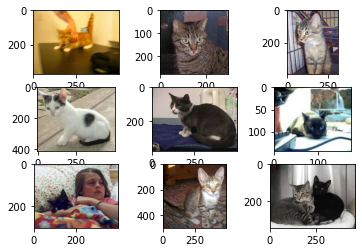

In [48]:
# plot random cat photos from original training dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = './train/'
# plot first few images
for i in range(9):
    rand_img = random.randint(0, 12499)
    plt.subplot(330 + 1 + i)
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

In [50]:
# display diagnostics
def display_diagnostics(history):
    # loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()

In [51]:
def load_image(filename):
    img = load_img(filename, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

In [52]:
# neural network training configurations
num_epochs = 5
learning_rate=0.001

In [53]:
# create cnn model
def create_cnn_model():
    # load base CNN architecture
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
#    base_model = VGG19(include_top=False, input_shape=(224, 224, 3))
#    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    for layer in base_model.layers:
        layer.trainable = False
    # add the remaining classifer neural network layers
    flatten_layer = Flatten()
    dense_layer_1 = Dense(128, activation='relu', kernel_initializer='he_uniform')
    prediction_layer = Dense(1, activation='sigmoid')
    cnn_model = Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        prediction_layer
    ])
    opt = SGD(learning_rate=learning_rate, momentum=0.9)
    cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model

In [54]:
# train model
def train_model():
    training_model = create_cnn_model()
    imgDataGenerator = ImageDataGenerator(featurewise_center=True)
    imgDataGenerator.mean = [123.68, 116.779, 103.939]
    training_set = imgDataGenerator.flow_from_directory('./dogs_v_cats/train/',
                        class_mode='binary', batch_size=64, target_size=(224, 224))
    validation_set = imgDataGenerator.flow_from_directory('./dogs_v_cats/validation/',
                        class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model and evaluate accuracy with each epoch
    history = training_model.fit(training_set, steps_per_epoch=len(training_set), 
                        validation_data=validation_set, validation_steps=len(validation_set), 
                        epochs=num_epochs, verbose=1)
    return training_model, history

In [55]:
model, history = train_model()

2022-05-22 18:59:41.239866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58889256/58889256 [==============================] - 2s 0us/step
Found 19999 images belonging to 2 classes.
Found 5001 images belonging to 2 classes.
Epoch 1/5
313/313 [==============================] - 5768s 18s/step - loss: 0.2429 - accuracy: 0.9663 - val_loss: 0.0744 - val_accuracy: 0.9724
Epoch 2/5
313/313 [==============================] - 5674s 18s/step - loss: 0.0275 - accuracy: 0.9902 - val_loss: 0.0852 - val_accuracy: 0.9744
Epoch 3/5
313/313 [==============================] - 5410s 17s/step - loss: 0.0075 - accuracy: 0.9983 - val_loss: 0.0948 - val_accuracy: 0.9764
Epoch 4/5
313/313 [==============================] - 5397s 17s/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.1125 - val_accuracy: 0.9758
Epoch 5/5
313/313 [==============================] - 5418s 17s/step - loss: 6.8601e-04 - accuracy: 1.0000 - val_loss: 0.1175 - val_accuracy: 0.9758


In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


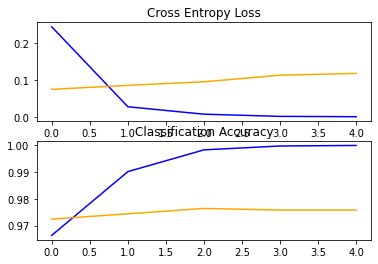

In [58]:
display_diagnostics(history)

In [60]:
model_filename = 'model_vgg16.h5'
#model_filename = 'model_vgg19.h5'
#model_filename = 'model_resnet50.h5'
model.save(model_filename)

In [61]:
final_model = load_model(model_filename)

In [62]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


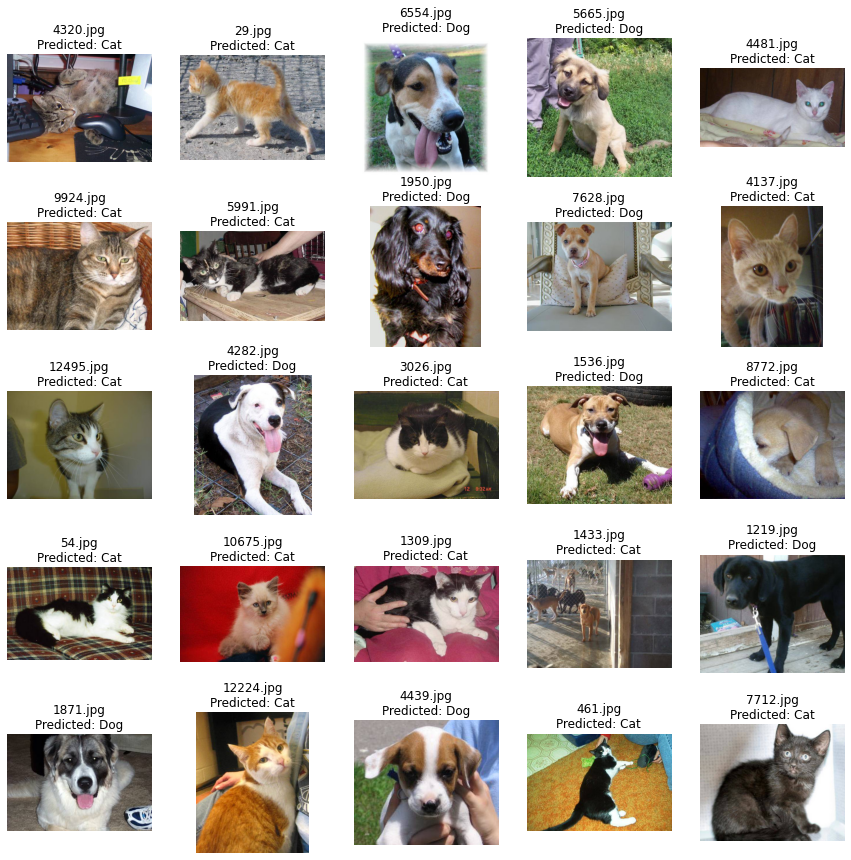

In [64]:
f, ax = plt.subplots(5,5, figsize=(15,15))

for i in range(0, 25):
    rand_img = random.randint(0, 12499)
    file_name = './test/' + str(rand_img) + '.jpg'
    file_name_stripped = str(rand_img) + '.jpg'
    img = load_image(file_name)
    result = final_model.predict(img, verbose=0)
    isDog = result[0][0].astype('int')
    if isDog: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(load_img(file_name))
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(file_name_stripped + "\nPredicted: {}".format(str_predicted))    
plt.show()

# Kaggle Submission

In [66]:
ids = []
labels = []
directory = 'test'

count = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        img = load_image(f)
        result = final_model.predict(img, verbose=0)
        label = result[0][0]
        filename_stripped = filename.replace('.jpg', '')
        this_id = int(filename_stripped)
        ids.append(this_id)
        labels.append(label)
        count+=1
        if (count%500==0):
            print(str(count) + ' completed')

print('DONE')

500 completed
1000 completed
1500 completed
2000 completed
2500 completed
3000 completed
3500 completed
4000 completed
4500 completed
5000 completed
5500 completed
6000 completed
6500 completed
7000 completed
7500 completed
8000 completed
8500 completed
9000 completed
9500 completed
10000 completed
10500 completed
11000 completed
11500 completed
12000 completed
12500 completed
DONE


In [67]:
# format result set into acceptable Kaggle submission by slightly padding 0 results and clipping 1 results
labels_edit = np.clip(labels, 0.025, 0.975)

In [69]:
submission = pd.DataFrame({'id':ids , 'label':labels_edit})
submission.head()
submission.to_csv("dog_v_cat_submission1.csv", index=False)

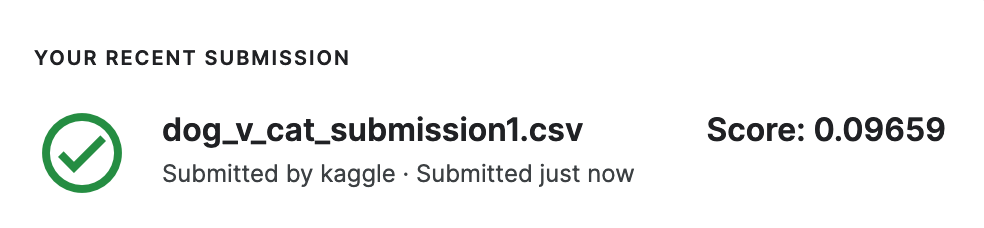